 # Time Series Partition, Naive Forecast, Forecast Accuracy and Residuals.

### Import required packages.

In [26]:
from pathlib import Path

import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools
from statsmodels.graphics import tsaplots
from statsmodels.tsa import stattools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from dmba import regressionSummary

import matplotlib.pylab as plt
%matplotlib inline


### Create templates for graph layout.

In [27]:
# Create a template for graph layout with partitions for data set. 
def Graph_Layout_Partition_Data():
    # Determine coordinates for drawing vertical lines and 
    # horizontal arrows on the chart.    
    one_month = pd.Timedelta('31 days')
    xtrain = (min(train_ts.index), max(train_ts.index) - one_month)
    xvalid = (min(valid_ts.index) + one_month, max(valid_ts.index) - one_month)
    xfuture = (max(valid_ts.index) + one_month, '2006')
    xtv = xtrain[1] + 0.5 * (xvalid[0] - xtrain[1])
    xvf = xvalid[1] + 0.5 * (xfuture[0] - xvalid[1])

    ax.axvline(x=xtv, ymin=0, ymax=1, color='black', linewidth=0.5)
    ax.axvline(x=xvf, ymin=0, ymax=1, color='black', linewidth=0.5)

    plt.annotate('', xy=('2001', 2250), xytext=('1991', 2250), 
              arrowprops=dict(arrowstyle="<->", shrinkA=0, shrinkB=0))
    plt.annotate('', xy=('2004', 2250), xytext=('2001-5', 2250), 
             arrowprops=dict(arrowstyle="<->", shrinkA=0, shrinkB=0))
    plt.annotate('', xy=('2006-5', 2250), xytext=('2004-5', 2250), 
             arrowprops=dict(arrowstyle="<->", shrinkA=0, shrinkB=0))

    # Input text on the arrows.
    ax.text('1995-6', 2300, 'Training')
    ax.text('2002-1', 2300, 'Validation')
    ax.text('2004-12', 2300, 'Future')

    # Create limits and axis labels.
    ax.set_xlim('1990', '2006-6')
    ax.set_ylim(1300, 2600)
    ax.set_xlabel('Time')
    ax.set_ylabel('Ridership (in 000s)')
    
# Create a template for graph layout with partitions for residuals. 
def Graph_Layout_Partition_Residuals():
    # Determine coordinates for drawing vertical lines and 
    # horizontal arrows on the chart.    
    one_month = pd.Timedelta('31 days')
    xtrain = (min(train_ts.index), max(train_ts.index) - one_month)
    xvalid = (min(valid_ts.index) + one_month, max(valid_ts.index) - one_month)
    xfuture = (max(valid_ts.index) + one_month, '2006')
    xtv = xtrain[1] + 0.5 * (xvalid[0] - xtrain[1])
    xvf = xvalid[1] + 0.5 * (xfuture[0] - xvalid[1])

    ax.axvline(x=xtv, ymin=0, ymax=1, color='black', linewidth=0.5)
    ax.axvline(x=xvf, ymin=0, ymax=1, color='black', linewidth=0.5)

    plt.annotate('', xy=('2001', 350), xytext=('1991', 350), 
              arrowprops=dict(arrowstyle="<->", shrinkA=0, shrinkB=0))
    plt.annotate('', xy=('2004', 350), xytext=('2001-5', 350), 
             arrowprops=dict(arrowstyle="<->", shrinkA=0, shrinkB=0))
    plt.annotate('', xy=('2006-5', 350), xytext=('2004-5', 350), 
             arrowprops=dict(arrowstyle="<->", shrinkA=0, shrinkB=0))

    # Input text on the arrows.
    ax.text('1995-6', 400, 'Training')
    ax.text('2002-1', 400, 'Validation')
    ax.text('2004-12', 400, 'Future')

    # Create limits and axis labels.
    ax.set_xlim('1990', '2006-6')
    ax.set_ylim(-500, 550)
    ax.set_xlabel('Time')
    ax.set_ylabel('Ridership (in 000s)')


# Create a template for graph layout with entire dataset and 12 periods 
# in future. 
def Graph_Layout_Entire_Data():
    # Determine coordinates for drawing vertical lines and horizontal 
    # arrows on the chart.
    one_month = pd.Timedelta('31 days')
    xridership = (min(ridership_ts.index), max(ridership_ts.index) - one_month)
    xfuture = (max(ridership_ts.index) + one_month, '2006')
    xvf = xridership[1] + 0.5 * (xfuture[0] - xridership[1])

    ax.axvline(x=xvf, ymin=0, ymax=1, color='black', linewidth=0.5)

    plt.annotate('', xy=('2004', 2250), xytext=('1991', 2250), 
              arrowprops=dict(arrowstyle="<->", shrinkA=0, shrinkB=0))
    plt.annotate('', xy=('2006-5', 2250), xytext=('2004-5', 2250), 
             arrowprops=dict(arrowstyle="<->", shrinkA=0, shrinkB=0))

    # Input text on the arrows.
    ax.text('1997', 2300, 'Training')
    ax.text('2004-10', 2300, 'Future')

    # Create limits and axis labels.
    ax.set_xlim('1990', '2006-6')
    ax.set_ylim(1300, 2600)
    ax.set_xlabel('Time')
    ax.set_ylabel('Ridership (in 000s)')

### Create measures of forecast accuracy.

In [28]:
# Create forcast accuracy measures.
def Forecast_Accuracy(actual, forecast):
    
    # ME - mean error
    me = round(np.mean(actual - forecast),3) 
    
    # RMSE - root mean square error (RMSE)
    rmse = round((np.mean((actual - forecast)**2)**.5),3)  
   
    # MAE - mean absolute error
    mae = round(np.mean(np.abs(actual - forecast)),3)   
   
    # MPE - mean percentage error,%
    mpe = round(((np.mean((actual - forecast)/actual))*100),3) 
    
    # MAPE - mean absolute percentage error, %
    mape = round(((np.mean(np.abs((actual - forecast)/actual)))*100),3) 
    
    # ACF1 - autocorrelation of errors at lag 1
    acf1 = round((acf(actual - forecast)[1]),3)                 
    
    return({'ME':me, 'RMSE':rmse, 'MAE':mae, 
            'MPE':mpe, 'MAPE':mape, 'ACF1':acf1})

### Create time series data set.

In [29]:
# Create data frame.
Amtrak_data = pd.read_csv('Amtrak.csv')

# Convert the date information to a datetime object 
# as monthly data.
Amtrak_data['Date'] = pd.to_datetime(Amtrak_data.Month, 
                         format='%m/%d/%Y')

# Convert data frame column to time series (name is used 
# to label the data).
ridership_ts = pd.Series(Amtrak_data.Ridership.values, 
                  index=Amtrak_data.Date, name='Ridership')

# Define the time series frequency.
ridership_ts.index = pd.DatetimeIndex(ridership_ts.index, 
                        freq=ridership_ts.index.inferred_freq)

# Show/print first 5 records of the time series dataset.
ridership_ts.head()

Date
1991-01-01    1708.917
1991-02-01    1620.586
1991-03-01    1972.715
1991-04-01    1811.665
1991-05-01    1974.964
Freq: MS, Name: Ridership, dtype: float64

### Create data partition and plot data partition. 

In [30]:
# Create a time series with additional linear trend term for 
# entire data set. 
# This will enable to develop training and validation forecasts 
# and plot them.
ridership_df = tsatools.add_trend(ridership_ts, trend='t')
print(ridership_df)

# Define the numbers of months in the training and validation sets,
# nTrain and nValid, respectively.
nValid = 36
nTrain = len(ridership_df) - nValid

# Partition the training data set and show (print) it. 
train_ts = ridership_df[:nTrain]
print('Training Data Set')
print(train_ts)

# Partition the validation data set and show (print) it. 
valid_ts = ridership_df[nTrain:]
print('')
print('Validation Data Set')
print(valid_ts.head())
print(valid_ts.tail())


            Ridership  trend
Date                        
1991-01-01   1708.917    1.0
1991-02-01   1620.586    2.0
1991-03-01   1972.715    3.0
1991-04-01   1811.665    4.0
1991-05-01   1974.964    5.0
...               ...    ...
2003-11-01   2076.054  155.0
2003-12-01   2140.677  156.0
2004-01-01   1831.508  157.0
2004-02-01   1838.006  158.0
2004-03-01   2132.446  159.0

[159 rows x 2 columns]
Training Data Set
            Ridership  trend
Date                        
1991-01-01   1708.917    1.0
1991-02-01   1620.586    2.0
1991-03-01   1972.715    3.0
1991-04-01   1811.665    4.0
1991-05-01   1974.964    5.0
...               ...    ...
2000-11-01   1981.408  119.0
2000-12-01   2000.153  120.0
2001-01-01   1683.148  121.0
2001-02-01   1663.404  122.0
2001-03-01   2007.928  123.0

[123 rows x 2 columns]

Validation Data Set
            Ridership  trend
Date                        
2001-04-01   2023.792  124.0
2001-05-01   2047.008  125.0
2001-06-01   2072.913  126.0
2001-07-01   2

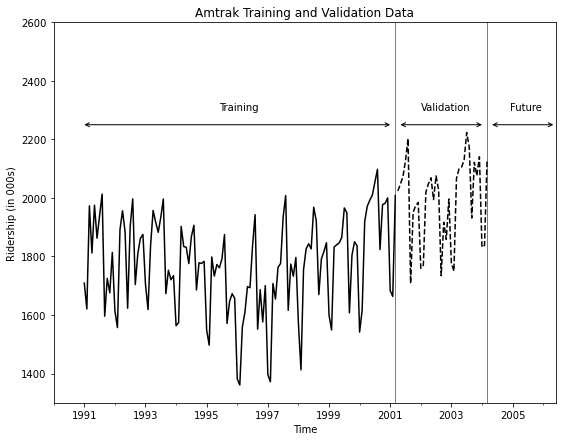

In [31]:
# Plot partitioned data. 

# Plot training data set.
ax = train_ts.plot(color='black', linewidth=1.5, figsize=(9,7))

# Plot valiation data set.
valid_ts.plot(ax = ax, color='black', linestyle='dashed', linewidth=1.5)

# Use template of graph layout for partitions. 
Graph_Layout_Partition_Data()

# Create graph legend and title.
plt.title('Amtrak Training and Validation Data')

# Set unnecessary legend invisible in the chart.  
ax.legend().set_visible(False)

plt.show()

### Fit regression models for training data. Forecast using validation set. Plot forecasts. 

In [32]:
# Fit a linear regression model to the time series with linear trend.
ridership_lin = sm.ols(formula='Ridership ~ trend', 
                       data=train_ts).fit()

# Fit a linear regression model to the time series with quadratic trend.
ridership_quad = sm.ols(formula='Ridership ~ trend + np.square(trend)', 
                       data=train_ts).fit()

# See (print) summary of forecasting equation and associated parameters. 
print('Linear Regression Parameters')
print(ridership_lin.summary())
print(' ')
print('Quadratic Regression Parameters')
print(ridership_quad.summary())

Linear Regression Parameters
                            OLS Regression Results                            
Dep. Variable:              Ridership   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.7456
Date:                Thu, 15 Oct 2020   Prob (F-statistic):              0.390
Time:                        14:40:33   Log-Likelihood:                -797.95
No. Observations:                 123   AIC:                             1600.
Df Residuals:                     121   BIC:                             1606.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1750.3595  

In [33]:
# Apply forecast to make predictions in training and validation sets.
ridership_lin_pred = ridership_lin.predict(valid_ts)
ridership_quad_pred = ridership_quad.predict(valid_ts)

# Show forecast for linear trend. 
print('Linear Trend forecast for Validation Set')
print(ridership_lin_pred.head())
print(ridership_lin_pred.tail())

# Show Forecast for quadratic trend.
print(' ')
print('Quadratic Trend Forecast for Validation Set')
print(ridership_quad_pred.head())
print(ridership_quad_pred.tail())



Linear Trend forecast for Validation Set
Date
2001-04-01    1793.929679
2001-05-01    1794.281051
2001-06-01    1794.632424
2001-07-01    1794.983796
2001-08-01    1795.335168
dtype: float64
Date
2003-11-01    1804.822218
2003-12-01    1805.173590
2004-01-01    1805.524962
2004-02-01    1805.876335
2004-03-01    1806.227707
dtype: float64
 
Quadratic Trend Forecast for Validation Set
Date
2001-04-01    1932.454168
2001-05-01    1939.508338
2001-06-01    1946.669753
2001-07-01    1953.938413
2001-08-01    1961.314317
dtype: float64
Date
2003-11-01    2201.002257
2003-12-01    2211.381015
2004-01-01    2221.867017
2004-02-01    2232.460264
2004-03-01    2243.160757
dtype: float64


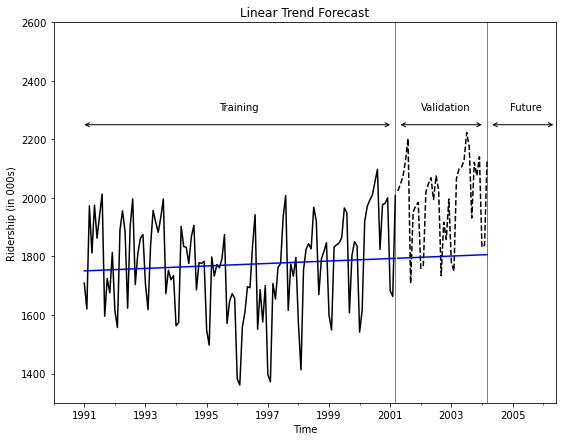

In [34]:
# Plot predictions for linear trend forecast. 

# Plot training and validation sets.
ax = train_ts.plot(color='black', linewidth=1.5, figsize=(9,7))
valid_ts.plot(ax=ax, color='black', linestyle='dashed', 
              linewidth=1.5)

# Plot linear trend forecast for training set. 
ridership_lin_pred_train = ridership_lin.predict(train_ts)
ridership_lin_pred_train.plot(ax = ax, color = 'blue')

# Plot linear trend forecast for validation set.
ridership_lin_pred.plot(ax = ax, color = 'blue')

# Use template of graph layout for partitions. 
Graph_Layout_Partition_Data()

# Create graph title.
plt.title('Linear Trend Forecast')

# Set unnecessary legend invisible in the chart.  
ax.legend().set_visible(False)

plt.show()

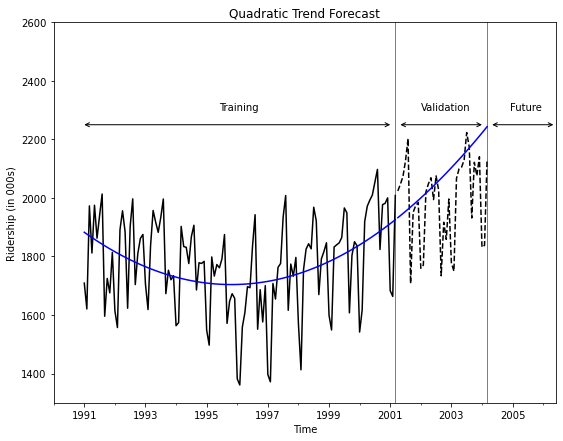

In [35]:
# Plot predictions for quadratic trend forecast. 

# Plot training and validation sets.
ax = train_ts.plot(color = 'black', linewidth=1.5, figsize=(9,7))
valid_ts.plot(ax = ax, color = 'black', linestyle='dashed', linewidth=1.5)

# Plot quadratic trend forecast for training set. 
ridership_quad_pred_train = ridership_quad.predict(train_ts)
ridership_quad_pred_train.plot(ax = ax, color = 'blue')

# Plot quadratic trend forecast for validation set.
ridership_quad_pred.plot(ax = ax, color = 'blue')

# Use template of graph layout for partitions. 
Graph_Layout_Partition_Data()

# Create graph title.
plt.title('Quadratic Trend Forecast')

# Set unnecessary legend invisible in the chart.  
ax.legend().set_visible(False)

plt.show()

### Identify Forecast Accuracy. 

In [36]:
# Reformat train_ts dataframe to train_ts_ref to incorporate 
# valiation data set only without trend parameter "t".
train_ts_ref = ridership_ts[:nTrain]

# Reformat valid_ts dataframe to valid_ts_ref to incorporate 
# valiation data set only without trend parameter "t".
valid_ts_ref = ridership_ts[nTrain:]

# Use regressionSummary() to identfiy common accuracy measures 
# for linear trend in validation data set.
print('       Accuracy Measures for Linear Trend')
regressionSummary(valid_ts_ref, ridership_lin_pred)

# Use regressionSummary() to identfiy common accuracy measures 
# for quadratic trend in validation data set.
print(' ')
print('       Accuracy Measures for Quadratic Trend')
regressionSummary(valid_ts_ref, ridership_quad_pred)


       Accuracy Measures for Linear Trend

Regression statistics

                      Mean Error (ME) : 193.1316
       Root Mean Squared Error (RMSE) : 239.4863
            Mean Absolute Error (MAE) : 209.4371
          Mean Percentage Error (MPE) : 9.2099
Mean Absolute Percentage Error (MAPE) : 10.1477
 
       Accuracy Measures for Quadratic Trend

Regression statistics

                      Mean Error (ME) : -83.9621
       Root Mean Squared Error (RMSE) : 179.8494
            Mean Absolute Error (MAE) : 133.7383
          Mean Percentage Error (MPE) : -4.7254
Mean Absolute Percentage Error (MAPE) : 7.0757


In [37]:
# Use Forecast_Accuracy(actual, forecast) function 
# defined in this file to identfiy common accuracy 
# measures for linear trend in validation data set.
print('Accuracy Measures for Linear Trend')
print(Forecast_Accuracy(valid_ts_ref, ridership_lin_pred))

# Use Forecast_Accuracy(actual, forecast) function 
# defined in this file to identfiy common accuracy 
# measures for quadratic trend in validation data set.
print(' ')
print('Accuracy Measures for Quadratic Trend')
print(Forecast_Accuracy(valid_ts_ref, ridership_quad_pred))

Accuracy Measures for Linear Trend
{'ME': 193.132, 'RMSE': 239.486, 'MAE': 209.437, 'MPE': 9.21, 'MAPE': 10.148, 'ACF1': 0.273}
 
Accuracy Measures for Quadratic Trend
{'ME': -83.962, 'RMSE': 179.849, 'MAE': 133.738, 'MPE': -4.725, 'MAPE': 7.076, 'ACF1': 0.417}


C:\Users\zinovy\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


### Identify Naive and Seasonal Naive Forecasts. 

In [38]:
# Generate naive forecast for training and validation data sets. 
# Take the previous value of train_ts_ref [:-1] and use it as naive 
# forecast for training data.
ridership_naive_pred_train = pd.Series(train_ts_ref[:-1].values, 
                        index=train_ts_ref[1:].index)
print('Naive Forecast for Training Data Set')
print(ridership_naive_pred_train)

# Take the last value of train_ts [-1] and use it as naive 
# forecast for validation valid_ts_ref data.
ridership_naive_pred = pd.Series(train_ts_ref[-1], 
                        index=valid_ts_ref.index)
print(' ')
print('Naive Forecast for Valiation Data Set')
print(ridership_naive_pred.head())
print(ridership_naive_pred.tail())




Naive Forecast for Training Data Set
Date
1991-02-01    1708.917
1991-03-01    1620.586
1991-04-01    1972.715
1991-05-01    1811.665
1991-06-01    1974.964
                ...   
2000-11-01    1976.997
2000-12-01    1981.408
2001-01-01    2000.153
2001-02-01    1683.148
2001-03-01    1663.404
Freq: MS, Length: 122, dtype: float64
 
Naive Forecast for Valiation Data Set
Date
2001-04-01    2007.928
2001-05-01    2007.928
2001-06-01    2007.928
2001-07-01    2007.928
2001-08-01    2007.928
Freq: MS, dtype: float64
Date
2003-11-01    2007.928
2003-12-01    2007.928
2004-01-01    2007.928
2004-02-01    2007.928
2004-03-01    2007.928
Freq: MS, dtype: float64


In [39]:
# Generate seasonal naive forecast for training and validation data sets. 
# Take 12 previous periods of train_ts_ref [:-12] and use it as seasonal 
# naive forecast for training data.
ridership_snaive_pred_train = pd.Series(train_ts_ref[:-12].values, 
                        index=train_ts_ref[12:].index)
print(' ')
print('Seasonal Naive Forecast for Training Data Set')
print(ridership_snaive_pred_train.head())
print(ridership_snaive_pred_train.tail())

# Generate the seasonal naive forecast for valiation data set.
# Last 12 periods of the training data set train_ts [-12:] to 
# be used for seasonal naive forecast.
last_season = train_ts_ref[-12:] 
print(' ')
print('Last 12 Months of Training Data Set')
# print(last_season)

# For naive seasonal forecast, multiple last_season, which is only 12 periods, 
# by the number of years (4) to ensure the seasonal naive forecast 
# for all validation periods. 
ridership_snaive_pred = pd.Series(pd.concat([last_season]*4)
                        [:len(valid_ts_ref)].values, index=valid_ts_ref.index)
print(" ")
print('Seasonal Naive Forecast for Valiation Data Set')
print(ridership_snaive_pred.head())
print(ridership_snaive_pred.tail())

 
Seasonal Naive Forecast for Training Data Set
Date
1992-01-01    1708.917
1992-02-01    1620.586
1992-03-01    1972.715
1992-04-01    1811.665
1992-05-01    1974.964
Freq: MS, dtype: float64
Date
2000-11-01    1850.309
2000-12-01    1836.435
2001-01-01    1541.660
2001-02-01    1616.928
2001-03-01    1919.538
Freq: MS, dtype: float64
 
Last 12 Months of Training Data Set
 
Seasonal Naive Forecast for Valiation Data Set
Date
2001-04-01    1971.493
2001-05-01    1992.301
2001-06-01    2009.763
2001-07-01    2053.996
2001-08-01    2097.471
Freq: MS, dtype: float64
Date
2003-11-01    1981.408
2003-12-01    2000.153
2004-01-01    1683.148
2004-02-01    1663.404
2004-03-01    2007.928
Freq: MS, dtype: float64


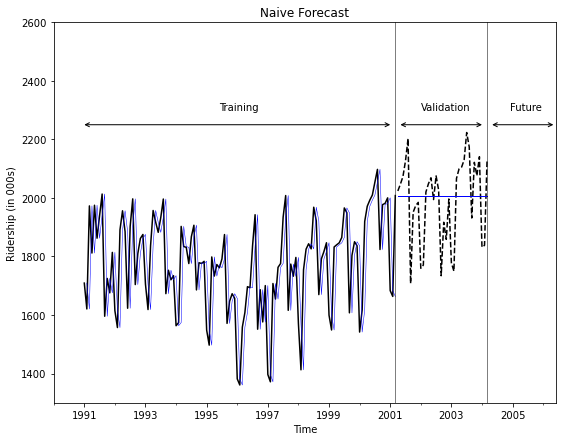

In [40]:
# Plot predictions for naive forecast. 

# Plot training and validation sets.
ax = train_ts.plot(color='black', linewidth=1.5, figsize=(9,7))
valid_ts.plot(ax=ax, color='black', linestyle='dashed', linewidth=1.5)

# Plot naive forecast for training and validation sets.
ridership_naive_pred_train.plot(ax = ax, color='blue', linewidth=0.5)
ridership_naive_pred.plot(ax = ax, color ='blue', linewidth=1.0)

# Use template of graph layout for partitions. 
Graph_Layout_Partition_Data()

# Create graph title.
plt.title('Naive Forecast')

# Set unnecessary legend invisible in the chart.  
ax.legend().set_visible(False)

plt.show()

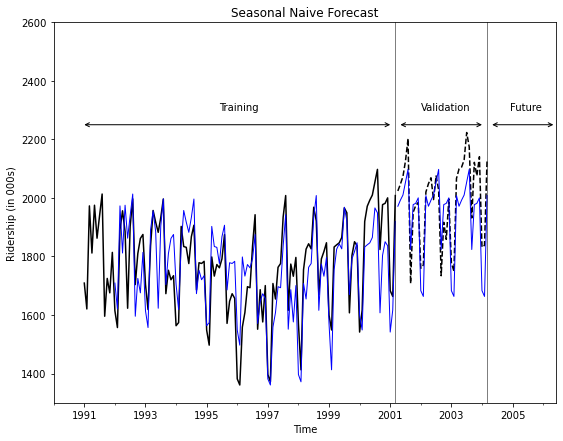

In [41]:
# Plot predictions for seasonal naive forecast. 

# Plot training and validation sets.
ax = train_ts.plot(color='black', linewidth=1.5, figsize=(9,7))
valid_ts.plot(ax=ax, color='black', linestyle='dashed', linewidth=1.5)

# Plot seasonal naive forecast for validation set.
ridership_snaive_pred_train.plot(ax = ax, color="blue", linewidth=1.0)
ridership_snaive_pred.plot(ax = ax, color="blue", linewidth=1.0)

# Use template of graph layout for partitions. 
Graph_Layout_Partition_Data()

# Create graph title.
plt.title('Seasonal Naive Forecast')

# Set unnecessary legend invisible in the chart.  
ax.legend().set_visible(False)

plt.show()

### Identify forecast accuracy for naive and seasonal naive forecasts. 

In [42]:
# Use regressionSummary() to identfiy common accuracy measures 
# for naive forecast in validation data set.
print('       Accuracy Measures for Naive Forecast')
regressionSummary(valid_ts_ref, ridership_naive_pred)

# Use regressionSummary() to identfiy common accuracy measures 
# for naive forecast in validation data set.
print(' ')
print('       Accuracy Measures for Seasonal Naive Forecast')
regressionSummary(valid_ts_ref, ridership_snaive_pred)

       Accuracy Measures for Naive Forecast

Regression statistics

                      Mean Error (ME) : -14.7177
       Root Mean Squared Error (RMSE) : 142.7551
            Mean Absolute Error (MAE) : 115.9234
          Mean Percentage Error (MPE) : -1.2750
Mean Absolute Percentage Error (MAPE) : 6.0214
 
       Accuracy Measures for Seasonal Naive Forecast

Regression statistics

                      Mean Error (ME) : 54.7296
       Root Mean Squared Error (RMSE) : 95.6243
            Mean Absolute Error (MAE) : 84.0941
          Mean Percentage Error (MPE) : 2.6528
Mean Absolute Percentage Error (MAPE) : 4.2477


In [43]:
# Use Forecast_Accuracy(actual, forecast) function 
# defined in this file to identfiy common accuracy 
# measures for naive forecast in validation data set.
print('Accuracy Measures for Naive Forecast')
print(Forecast_Accuracy(valid_ts_ref, ridership_naive_pred))

# Use Forecast_Accuracy(actual, forecast) function 
# defined in this file to identfiy common accuracy 
# measures for seasonal naive forecast in validation data set.
print(' ')
print('Accuracy Measures for Seasonal Naive Forecast')
print(Forecast_Accuracy(valid_ts_ref, ridership_snaive_pred))

Accuracy Measures for Naive Forecast
{'ME': -14.718, 'RMSE': 142.755, 'MAE': 115.923, 'MPE': -1.275, 'MAPE': 6.021, 'ACF1': 0.276}
 
Accuracy Measures for Seasonal Naive Forecast
{'ME': 54.73, 'RMSE': 95.624, 'MAE': 84.094, 'MPE': 2.653, 'MAPE': 4.248, 'ACF1': 0.637}


C:\Users\zinovy\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


### Identify forecast errors for quadratic trend forecast. Plot forecast errors. Develop error histogram. 

In [44]:
# Use actual and forecasted values for training data set to 
# identify training errors (residuals).
ridership_train_res = train_ts.Ridership - ridership_quad_pred_train
print('Training Errors for Quadratic Trend Forecast')
print(ridership_train_res)

# Use actual and forecasted values for validation data set to 
# identify validation errors (residuals).
ridership_valid_res = valid_ts.Ridership - ridership_quad_pred
print(' ')
print('Validation Errors for Quadratic Trend Forecast')
print(ridership_valid_res.head())
print(ridership_valid_res.tail())

Training Errors for Quadratic Trend Forecast
Date
1991-01-01   -173.722832
1991-02-01   -255.916896
1991-03-01    102.241795
1991-04-01    -52.885758
1991-05-01    116.228444
                 ...    
2000-11-01     82.616011
2000-12-01     94.843064
2001-01-01   -228.787127
2001-02-01   -255.263562
2001-03-01     82.420757
Freq: MS, Length: 123, dtype: float64
 
Validation Errors for Quadratic Trend Forecast
Date
2001-04-01     91.337832
2001-05-01    107.499662
2001-06-01    126.243247
2001-07-01    172.778587
2001-08-01    241.323683
Freq: MS, dtype: float64
Date
2003-11-01   -124.948257
2003-12-01    -70.704015
2004-01-01   -390.359017
2004-02-01   -394.454264
2004-03-01   -110.714757
Freq: MS, dtype: float64


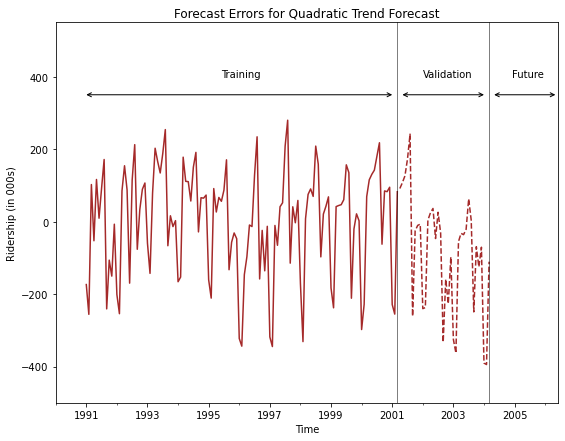

In [45]:
# Plot forecast errors for quadratic trend forecast. 
ax = ridership_train_res.plot(color='brown', linewidth=1.5, figsize=(9,7))
ridership_valid_res.plot(ax=ax, color='brown', linestyle='dashed', linewidth=1.5)

# Use template of graph layout for partitions. 
Graph_Layout_Partition_Residuals()

# Create graph title.
plt.title('Forecast Errors for Quadratic Trend Forecast')

# Set unnecessary legend invisible in the chart.  
ax.legend().set_visible(False)

plt.show()


1.0


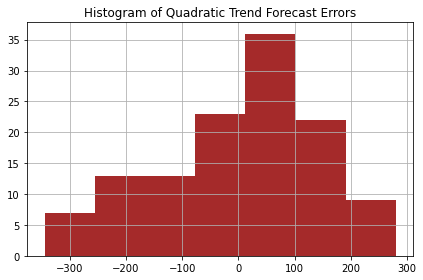

In [46]:
# Use hist() function to develop histogram for the model residuals. 

# Determine the percentage of datapoints with a residual in 
# [-400, 400] = approx. 75\%
print(len(ridership_train_res[(ridership_train_res > -400) 
             & (ridership_train_res < 400)]) / len(ridership_train_res))

ax = pd.DataFrame({'Histogram of Quadratic Trend Forecast Errors'
                   : ridership_train_res}).hist(bins=7, color = 'brown')

plt.tight_layout()

plt.show()
